In [41]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, task="classification", lr=0.01, seed=None):
        if task not in {"classification", "regression"}:
            raise ValueError("task must be 'classification' or 'regression'")
        self.layer_sizes = layer_sizes
        self.task = task
        self.lr = lr
        rng = np.random.default_rng(seed)

        self.W = [rng.normal(0, np.sqrt(2 / layer_sizes[i]),
                             size=(layer_sizes[i], layer_sizes[i + 1]))
                  for i in range(len(layer_sizes) - 1)]
        self.b = [np.zeros((1, sz)) for sz in layer_sizes[1:]]

        self.z_s = []  
        self.a_s = []  

    @staticmethod
    def _relu(z):
        return np.maximum(0, z)

    @staticmethod
    def _d_relu(z):
        return (z > 0).astype(float)

    @staticmethod
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def forward(self, X):
        a = X
        self.z_s = []
        self.a_s = [X]

        for W, b in zip(self.W[:-1], self.b[:-1]):
            z = a @ W + b
            a = self._relu(z)
            self.z_s.append(z)
            self.a_s.append(a)

        z = a @ self.W[-1] + self.b[-1]
        self.z_s.append(z)

        if self.task == "classification":
            if z.shape[1] == 1:
                a = self._sigmoid(z)
            else:  
                e = np.exp(z - z.max(axis=1, keepdims=True))
                a = e / e.sum(axis=1, keepdims=True)
        else:  
            a = z

        self.a_s.append(a)
        return a

    def _loss(self, y_hat, y):
        if self.task == "classification":
            eps = 1e-12
            return -np.mean(np.sum(y * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps), axis=1))
        return 0.5 * np.mean((y_hat - y) ** 2)

    def _d_loss(self, y_hat, y):
        if self.task == "classification":
            return (y_hat - y) / y.shape[0]
        return (y_hat - y) / y.shape[0]

    def _backward(self, y):
        grads_W, grads_b = [], []
        delta = self._d_loss(self.a_s[-1], y)  

        grads_W.append(self.a_s[-2].T @ delta)
        grads_b.append(delta.sum(axis=0, keepdims=True))

        for l in range(len(self.W) - 2, -1, -1):
            z = self.z_s[l]
            delta = (delta @ self.W[l + 1].T) * self._d_relu(z)
            grads_W.append(self.a_s[l].T @ delta)
            grads_b.append(delta.sum(axis=0, keepdims=True))

        grads_W.reverse()
        grads_b.reverse()
        return grads_W, grads_b

    def _step(self, grads_W, grads_b):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * grads_W[i]
            self.b[i] -= self.lr * grads_b[i]

    def fit_epoch(self, X, y, batch_size=32, shuffle=True):
        idx = np.arange(len(X))
        if shuffle:
            np.random.shuffle(idx)
        X, y = X[idx], y[idx]
        losses = []
        for start in range(0, len(X), batch_size):
            xb = X[start:start + batch_size]
            yb = y[start:start + batch_size]
            y_hat = self.forward(xb)
            loss = self._loss(y_hat, yb)
            grads_W, grads_b = self._backward(yb)
            self._step(grads_W, grads_b)
            losses.append(loss)
        return float(np.mean(losses))

    # prediction helpers
    def predict(self, X):
        y_hat = self.forward(X)
        if self.task == "classification":
            if y_hat.shape[1] == 1:
                return (y_hat >= 0.5).astype(int)
            return y_hat.argmax(axis=1)
        return y_hat

    def predict_proba(self, X):
        return self.forward(X)


In [43]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
X = df.drop("Churn", axis=1).astype(float)
y = df["Churn"].values.reshape(-1, 1).astype(float)

In [49]:
df = pd.read_csv("data.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
df.dropna(inplace=True) 
df.drop("customerID", axis=1, inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [51]:
binary_cols = [
    "gender", "Partner", "Dependents",
    "PhoneService", "PaperlessBilling"
]

multi_service_cols = [
    "MultipleLines", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"
]

multi_class_cols = [
    "InternetService", "Contract", "PaymentMethod"
]

In [53]:
for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0, "Male": 1, "Female": 0})
for col in multi_service_cols:
    df[col] = df[col].replace({"No internet service": "No", "No phone service": "No"})
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [55]:
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)

In [57]:
print(df.dtypes)
df.head()  

gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PhoneService                               int64
MultipleLines                              int64
OnlineSecurity                             int64
OnlineBackup                               int64
DeviceProtection                           int64
TechSupport                                int64
StreamingTV                                int64
StreamingMovies                            int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
InternetService_Fiber optic                 bool
InternetService_No                          bool
Contract_One year                           bool
Contract_Two year   

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,1,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,True,False,False,False,False,True,False


In [63]:
X = df.drop("Churn", axis=1).astype(float)
y = df["Churn"].values.reshape(-1, 1).astype(float)

In [65]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
scaler = StandardScaler().fit(X_train[numeric_cols])

X_train.loc[:, numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val.loc[:,   numeric_cols] = scaler.transform(X_val[numeric_cols])

X_train = X_train.values
X_val   = X_val.values

In [67]:
net = NeuralNetwork(
        layer_sizes=[X_train.shape[1], 32, 16, 1],
        task="classification",
        lr=0.01,
        seed=42)

In [69]:
n_epochs  = 120
batch_size = 64

train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

In [71]:
for epoch in range(1, n_epochs + 1):
    t0   = time.time()
    tr_l = net.fit_epoch(X_train, y_train, batch_size=batch_size)

    y_hat_val = net.forward(X_val)
    val_l     = net._loss(y_hat_val, y_val)          
    val_acc   = ((y_hat_val >= 0.5).astype(int) == y_val).mean()

    train_loss_hist.append(tr_l)
    val_loss_hist.append(val_l)
    val_acc_hist.append(val_acc)

    if epoch % 10 == 0 or epoch == 1:
        dt = time.time() - t0
        print(f"{epoch:3d}/{n_epochs}  "
              f"train {tr_l:.4f}  val {val_l:.4f}  acc {val_acc:.3f}  "
              f"{dt:.1f}s")

  1/120  train 0.5783  val 0.5279  acc 0.743  0.1s
 10/120  train 0.4304  val 0.4436  acc 0.783  0.0s
 20/120  train 0.4200  val 0.4373  acc 0.795  0.0s
 30/120  train 0.4151  val 0.4345  acc 0.796  0.0s
 40/120  train 0.4119  val 0.4336  acc 0.797  0.0s
 50/120  train 0.4098  val 0.4327  acc 0.796  0.0s
 60/120  train 0.4083  val 0.4326  acc 0.797  0.0s
 70/120  train 0.4071  val 0.4321  acc 0.790  0.0s
 80/120  train 0.4059  val 0.4320  acc 0.793  0.0s
 90/120  train 0.4049  val 0.4323  acc 0.797  0.0s
100/120  train 0.4040  val 0.4319  acc 0.795  0.0s
110/120  train 0.4031  val 0.4314  acc 0.789  0.0s
120/120  train 0.4023  val 0.4317  acc 0.794  0.0s


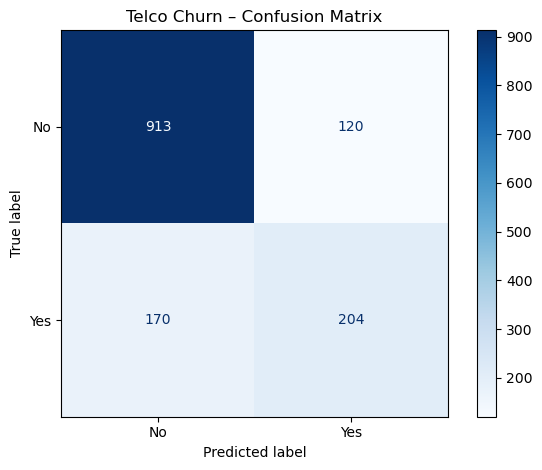

In [73]:
y_pred = (net.forward(X_val) >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(
    cm, display_labels=["No", "Yes"]
).plot(cmap="Blues", values_format="d")
plt.title("Telco Churn – Confusion Matrix")
plt.tight_layout()
plt.show()


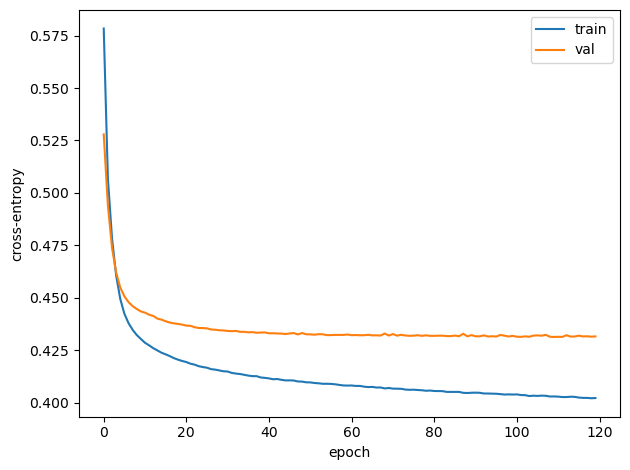

In [75]:
plt.figure()
plt.plot(train_loss_hist, label="train")
plt.plot(val_loss_hist,   label="val")
plt.xlabel("epoch"); plt.ylabel("cross-entropy")
plt.legend(); plt.tight_layout(); plt.show()


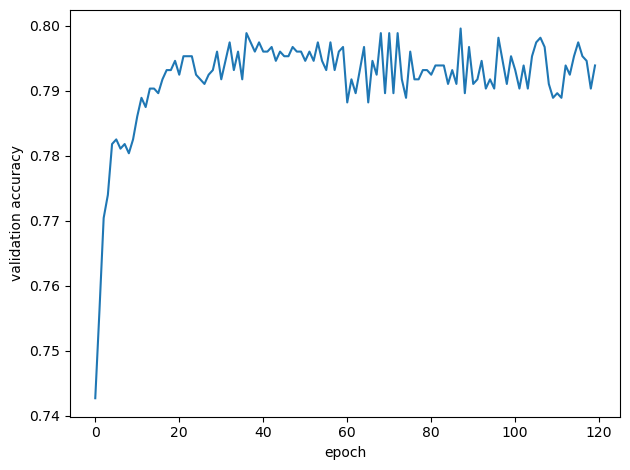

In [77]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel("epoch"); plt.ylabel("validation accuracy")
plt.tight_layout(); plt.show()